## Empirical estimate of program effect

In this file, empirical methods are applied to analyze the effect of the small business training program

### Globals and packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as smf
from scipy import stats

In [42]:
def fit_wls(formula_str):
    mod = smf.wls(f'log_prod ~ {formula_str}', data=df, weights=df['sw'])
    res = mod.fit(cov_type='cluster', cov_kwds={'groups': df['firm_id']})
    return res

def stars(p):
    return '***' if p<0.01 else ('**' if p<0.05 else ('*' if p<0.10 else ''))

def smd(x_t, x_c, w_t=None, w_c=None):
    if w_t is None: w_t = np.ones_like(x_t, dtype=float)
    if w_c is None: w_c = np.ones_like(x_c, dtype=float)
    mt = np.average(x_t, weights=w_t); mc = np.average(x_c, weights=w_c)
    vt = np.average((x_t-mt)**2, weights=w_t); vc = np.average((x_c-mc)**2, weights=w_c)
    return (mt-mc)/np.sqrt(0.5*(vt+vc))

def mark(v): return r'\cmark' if v else r'\xmark'

def latex_escape(s):
    if s is None:
        return ''
    return str(s).replace('&','\\&').replace('%','\\%').replace('_','\\_').replace('#','\\#').replace('$','\\$')

def build_features(zz, use_sector):
    Zb = zz[['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']].copy()
    if use_sector and 'firm_sector' in zz.columns:
        Zb = pd.concat([Zb, pd.get_dummies(zz['firm_sector'], prefix='sec', drop_first=True)], axis=1).astype(float)
    return Zb

### Propensity score with DID

#### Read in data

In [7]:
df = pd.read_csv('aggregate_firm_final_filled.csv')
# make sure that date is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['firm_id','date']).copy()
df['post'] = (df['date'] >= pd.Timestamp('2013-01-01')).astype(int)

# Here for productivity level, we use sales per employee as a proxy
for col in ['revenue_t','employment_t','adopt_t', 'sales_t', 'wage_bill_t']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['prod'] = df['revenue_t'] / df['employment_t']
df['log_prod'] = np.log(df['prod'])

# drop observations with missing productivity level
df = df.dropna(subset=['log_prod']).copy()

# cross product term for diff-in-diff
firm_post_adopt = (
    df.loc[df['post']==1]
      .groupby('firm_id')['adopt_t'].max()
      .rename('treat')
      .fillna(0)
      .astype(int)
)
df = df.merge(firm_post_adopt, on='firm_id', how='left')
df['treat'] = df['treat'].fillna(0).astype(int)
df['did'] = df['treat'] * df['post']

In [8]:
# Since firms opt to be in such a program, to avoid selection bias, we use PSM to create a control group
pre = df.loc[df['post']==0].copy()
agg_cov = (
    pre.groupby('firm_id')
       .agg(
            emp_mean = ('employment_t','mean'),
            rev_mean = ('revenue_t','mean'),
            sales_mean = ('sales_t','mean') if 'sales_t' in pre.columns else ('revenue_t','mean'),
            emp_std = ('employment_t','std'),
            rev_std = ('revenue_t','std')
       )
       .reset_index()
)

# use the mean value before 2013 as baseline
pre['year'] = pre['date'].dt.year
base = pre.loc[pre['year']<2013].groupby('firm_id').agg(
    emp_2012=('employment_t','mean'),
    rev_2012=('revenue_t','mean')
).reset_index()

sector = pre.groupby('firm_id')['firm_sector'].agg(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan).reset_index()
X_firm = (
    firm_post_adopt.reset_index()
    .merge(agg_cov, on='firm_id', how='left')
    .merge(base, on='firm_id', how='left')
    .merge(sector, on='firm_id', how='left')
)

# Fill the missing values in covariates with mean/median
num_cols = ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']
for c in num_cols:
    if c in X_firm.columns:
        X_firm[c] = pd.to_numeric(X_firm[c], errors='coerce')
        X_firm[c] = X_firm[c].fillna(X_firm[c].median())
# Categorical columns
cat_cols = ['firm_sector'] if 'firm_sector' in X_firm.columns else []
y = X_firm['treat'].values

# PSM model
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True, with_std=True), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='drop'
)

ps_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

ps_model.fit(X_firm[num_cols + cat_cols], y)
ps = ps_model.predict_proba(X_firm[num_cols + cat_cols])[:,1]
X_firm['ps'] = ps

print(f'Propensity score AUC: {roc_auc_score(y, ps):.3f}')

Propensity score AUC: 0.897


In [9]:
# Trim extreme PS values and stabilize weights
X_firm = X_firm[(X_firm['ps']>0.05) & (X_firm['ps']<0.95)].copy()
pbar = X_firm['treat'].mean()
X_firm['sw'] = np.where(
    X_firm['treat']==1,
    pbar / X_firm['ps'],
    (1-pbar) / (1 - X_firm['ps'])
)
# get weight back to the panel
df = df.merge(X_firm[['firm_id','ps','sw']], on='firm_id', how='inner')

In [12]:
# Main DID regression with PS weights
if 't' not in df.columns:
    df['t'] = df['date'].dt.to_period('M').astype(int)

specs = [
    {'name': '(1)', 'formula': 'did',                                              'firm_fe': False, 'time_fe': False, 'sect_trend': False},
    {'name': '(2)', 'formula': 'did + C(firm_id)',                                 'firm_fe': True,  'time_fe': False, 'sect_trend': False},
    {'name': '(3)', 'formula': 'did + C(firm_id) + C(date)',                       'firm_fe': True,  'time_fe': True,  'sect_trend': False},
    {'name': '(4)', 'formula': 'did + C(firm_id) + C(date) + C(firm_sector):t',    'firm_fe': True,  'time_fe': True,  'sect_trend': True},
]

results = []
for s in specs:
    res = fit_wls(s['formula'])
    b = float(res.params.get('did', np.nan))
    se = float(res.bse.get('did', np.nan))
    p = float(res.pvalues.get('did', np.nan))
    results.append({
        'name': s['name'], 'b': b, 'se': se, 'p': p,
        'firm_fe': s['firm_fe'], 'time_fe': s['time_fe'], 'sect_trend': s['sect_trend'],
        'n': int(res.nobs), 'r2': float(getattr(res, 'rsquared', np.nan))
    })

/Users/wangchengrui11/Desktop/PhD_application/Stanford_Data_Task_2025/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [13]:
# LaTeX table
colN = len(results)
header_specs = ' & ' + ' & '.join(r['name'] for r in results) + r' \\'
coef_row = 'Post*Treat'
coef_vals = ' & '.join([f"{r['b']:.3f}{stars(r['p'])}" for r in results])
se_vals = ' & '.join([f"({r['se']:.3f})" for r in results])

firm_fe_row = 'Firm fixed effects'
firm_fe_vals = ' & '.join([mark(r['firm_fe']) for r in results])
time_fe_row = 'Time fixed effects'
time_fe_vals = ' & '.join([mark(r['time_fe']) for r in results])
sect_trend_row = 'Sector * Time trend'
sect_trend_vals = ' & '.join([mark(r['sect_trend']) for r in results])

n_row = 'N'
n_vals = ' & '.join([f"{r['n']:,}" for r in results])
r2_row = r'$R^2$'
r2_vals = ' & '.join([f"{r['r2']:.3f}" if np.isfinite(r['r2']) else '' for r in results])

latex_table = rf"""
\begin{{table}}[!htbp]\centering
\caption{{PSM-DID Estimation Results}}
\label{{tab:did_specs}}
\begin{{threeparttable}}
\begin{{tabular}}{{l*{{{colN}}}{{c}}}}
\toprule
 & {header_specs}
\midrule
{coef_row} & {coef_vals} \\
           & {se_vals} \\
\midrule
{firm_fe_row} & {firm_fe_vals} \\
{time_fe_row} & {time_fe_vals} \\
{sect_trend_row} & {sect_trend_vals} \\
\midrule
{n_row} & {n_vals} \\
{r2_row} & {r2_vals} \\
\bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\footnotesize
\item Note: Dependent variable is the logarithm of productivity, and all models use propensity score stabilized weights (WLS), with standard errors clustered at the firm level. Robust standard errors are reported in parentheses. $^{{***}}p<0.01$, $^{{**}}p<0.05$, $^{{*}}p<0.10$.
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
""".strip()

out_dir = os.path.join(os.getcwd(), 'table')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'psm_did_impute.tex')
with open(out_path, 'w') as f:
    f.write(latex_table)


In [14]:
# Get the direct parameter estimate and 95% CI
tau = res.params.get('did', np.nan)
se = res.bse.get('did', np.nan)
ci_low = tau - 1.96*se
ci_high = tau + 1.96*se
print(f"log(productivity) increases by: {tau:.4f}, 95% CI [{ci_low:.4f}, {ci_high:.4f}] after adopting the program")

log(productivity) increases by: 0.3939, 95% CI [0.3233, 0.4645] after adopting the program


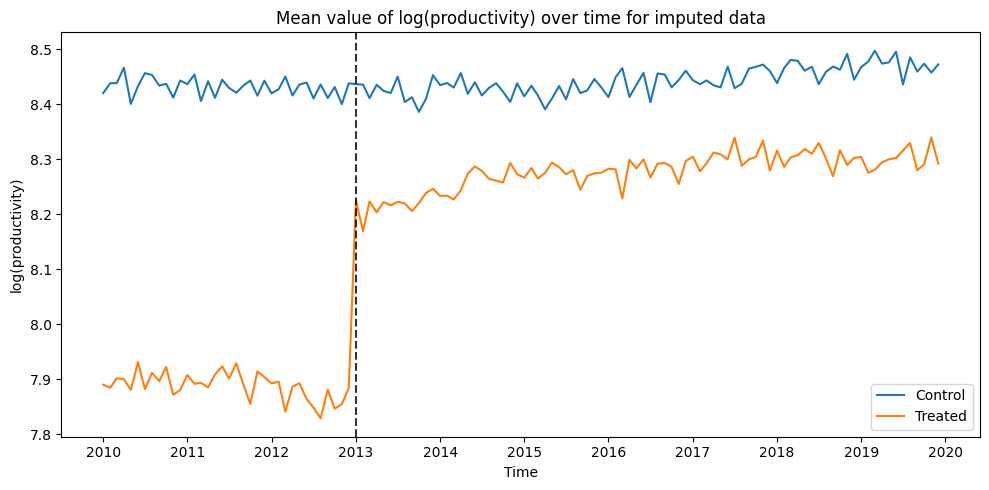

In [16]:
# Visualization of PSM distribution
trend = (
    df.groupby(['date','treat'])['log_prod']
      .mean()
      .reset_index()
)
plt.figure(figsize=(10,5))
for g, d in trend.groupby('treat'):
    label = 'Treated' if g==1 else 'Control'
    plt.plot(d['date'], d['log_prod'], label=label)
plt.axvline(pd.Timestamp('2013-01-01'), color='k', linestyle='--', alpha=0.8)
plt.title('Mean value of log(productivity) over time for imputed data')
plt.xlabel('Time')
plt.ylabel('log(productivity)')
plt.legend()
plt.tight_layout()
plt.show()

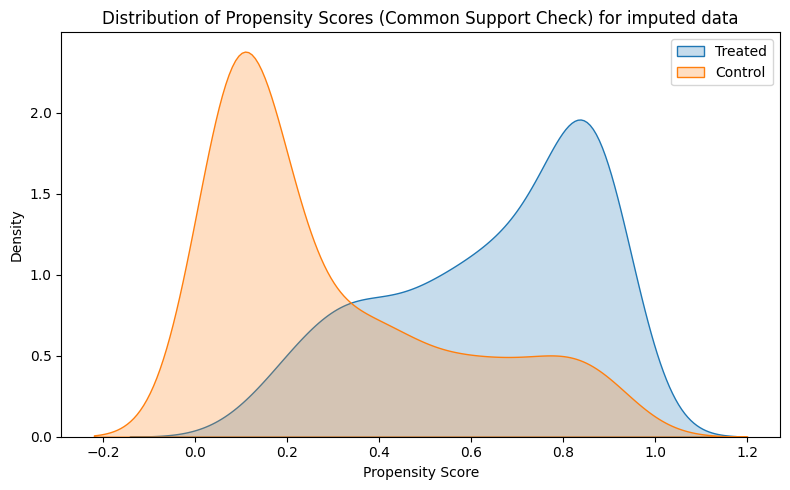

In [18]:
# PS distribution check
plt.figure(figsize=(8,5))
sns.kdeplot(X_firm.loc[X_firm['treat']==1,'ps'], label='Treated', fill=True)
sns.kdeplot(X_firm.loc[X_firm['treat']==0,'ps'], label='Control', fill=True)
plt.title('Distribution of Propensity Scores (Common Support Check) for imputed data')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

       cov   smd_unw     smd_w
  emp_mean -1.398443 -0.052916
  rev_mean -1.275835 -0.025049
sales_mean -1.326557 -0.014120
   emp_std -1.263466 -0.004280
   rev_std -1.138948  0.018470
  emp_2012 -1.398443 -0.052916
  rev_2012 -1.275835 -0.025049


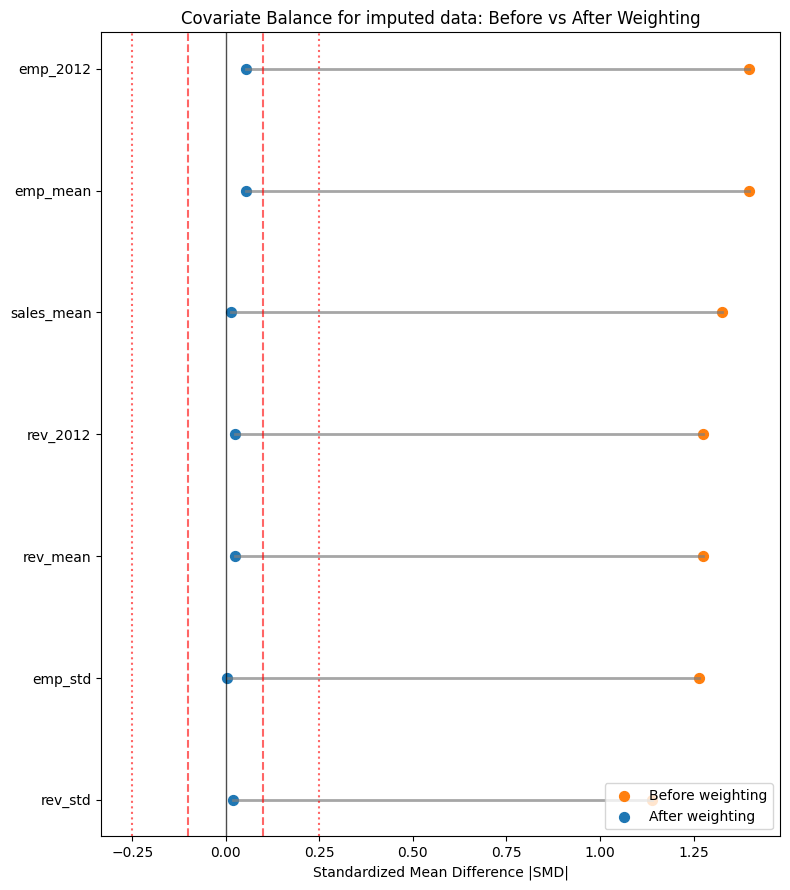

In [26]:
def smd(x_t, x_c, w_t=None, w_c=None):
    if w_t is None: w_t = np.ones_like(x_t, dtype=float)
    if w_c is None: w_c = np.ones_like(x_c, dtype=float)
    mt = np.average(x_t, weights=w_t); mc = np.average(x_c, weights=w_c)
    vt = np.average((x_t-mt)**2, weights=w_t); vc = np.average((x_c-mc)**2, weights=w_c)
    return (mt-mc)/np.sqrt(0.5*(vt+vc))

covs = ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']
tmp = X_firm.copy()
rows = []
for c in covs:
    a = pd.to_numeric(tmp.loc[tmp['treat']==1, c], errors='coerce').dropna()
    b = pd.to_numeric(tmp.loc[tmp['treat']==0, c], errors='coerce').dropna()
    wa = tmp.loc[a.index, 'sw'].fillna(1).to_numpy()
    wb = tmp.loc[b.index, 'sw'].fillna(1).to_numpy()

    smd_unw = smd(a.to_numpy(), b.to_numpy())
    smd_w   = smd(a.to_numpy(), b.to_numpy(), wa, wb)
    rows.append({'cov': c, 'smd_unw': smd_unw, 'smd_w': smd_w})

# Balance table
bal_df = pd.DataFrame(rows)
bal_df['abs_unw'] = bal_df['smd_unw'].abs()
bal_df['abs_w']   = bal_df['smd_w'].abs()
print(bal_df[['cov','smd_unw','smd_w']].to_string(index=False))

# Balance plot
order = bal_df.sort_values('abs_unw', ascending=True)['cov'].tolist()
plt.figure(figsize=(8, 1.0*len(order) + 2))
for i, cov in enumerate(order):
    x0 = bal_df.loc[bal_df['cov']==cov, 'abs_unw'].values[0]
    x1 = bal_df.loc[bal_df['cov']==cov, 'abs_w'].values[0]
    plt.plot([x0, x1], [i, i], color='gray', linewidth=2, alpha=0.7)
    plt.scatter(x0, i, color='tab:orange', s=50, label='Before weighting' if i==0 else "")
    plt.scatter(x1, i, color='tab:blue', s=50, label='After weighting' if i==0 else "")

for thr, ls in [(0.1, '--'), (0.25, ':')]:
    plt.axvline(thr, color='red', linestyle=ls, alpha=0.6)
    plt.axvline(-thr, color='red', linestyle=ls, alpha=0.6)
plt.axvline(0, color='k', linewidth=1, alpha=0.7)

plt.yticks(range(len(order)), order)
plt.xlabel('Standardized Mean Difference |SMD|')
plt.title('Covariate Balance for imputed data: Before vs After Weighting')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [20]:
# Event analysis for parallel trends check
month_index = df['date'].dt.to_period('M').astype(int)
t0 = pd.Period('2013-01', freq='M').ordinal  
df['rel_m'] = month_index - t0

# consider a window of +- 24 months
df_es = df[(df['rel_m']>=-24) & (df['rel_m']<=24)].copy()

# Create lead/lag indicators
for k in range(-24, 25):
    if k == -1:
        continue
    df_es[f'leadlag_{k}'] = ((df_es['rel_m']==k) & (df_es['treat']==1)).astype(int)

# Key regression for event study
terms = ' + '.join([f"Q('leadlag_{k}')" for k in range(-24, 25) if k != -1])
formula_es = f'log_prod ~ {terms} + C(firm_sector) + C(date)'
mod_es = smf.wls(formula_es, data=df_es, weights=df_es['sw'])
res_es = mod_es.fit(cov_type='cluster', cov_kwds={'groups': df_es['firm_id']})


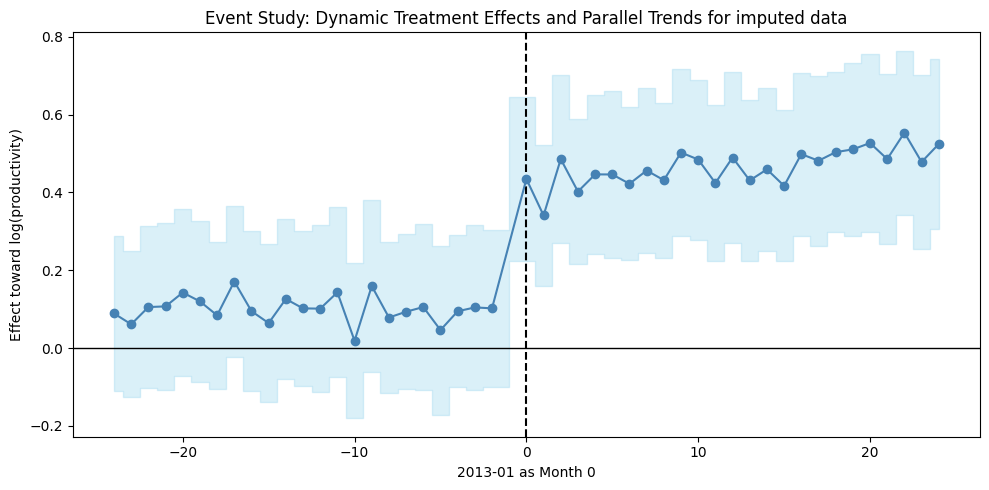

In [25]:
# Get coefficients and CIs
betas, lower, upper, rel = [], [], [], []
for k in range(-24, 25):
    if k == -1:
        continue
    name = f"Q('leadlag_{k}')"
    b = res_es.params.get(name, np.nan)
    se = res_es.bse.get(name, np.nan)
    if pd.notna(b) and pd.notna(se):
        betas.append(b)
        lower.append(b - 1.96*se)
        upper.append(b + 1.96*se)
        rel.append(k)

# Plot event study results
es_df = pd.DataFrame({'rel_m': rel, 'beta': betas, 'lo': lower, 'hi': upper}).sort_values('rel_m')

plt.figure(figsize=(10,5))
plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linestyle='--')
plt.fill_between(es_df['rel_m'], es_df['lo'], es_df['hi'], color='skyblue', alpha=0.3, step='mid')
plt.plot(es_df['rel_m'], es_df['beta'], color='steelblue', marker='o')
plt.title('Event Study: Dynamic Treatment Effects and Parallel Trends for imputed data')
plt.xlabel('2013-01 as Month 0')
plt.ylabel('Effect toward log(productivity)')
plt.tight_layout()
plt.show()

In [22]:
# Joint test for pre-trends
pre_coefs = [f"Q('leadlag_{k}')" for k in range(-24, 0) if k != -1]
if len(pre_coefs) > 0:
    R = np.zeros((len(pre_coefs), len(res_es.params)))
    param_names = res_es.params.index.tolist()
    rows = []
    for i, name in enumerate(pre_coefs):
        if name in param_names:
            j = param_names.index(name)
            R[i, j] = 1.0
            rows.append(name)
    if rows:
        wald = res_es.wald_test(R, use_f=True, scalar=True)
        print('Parallel Trends (Joint Test for Pre-Trends):', wald)

Parallel Trends (Joint Test for Pre-Trends): <F test: F=1.2273846726257602, p=0.21742790660705302, df_denom=354, df_num=23>


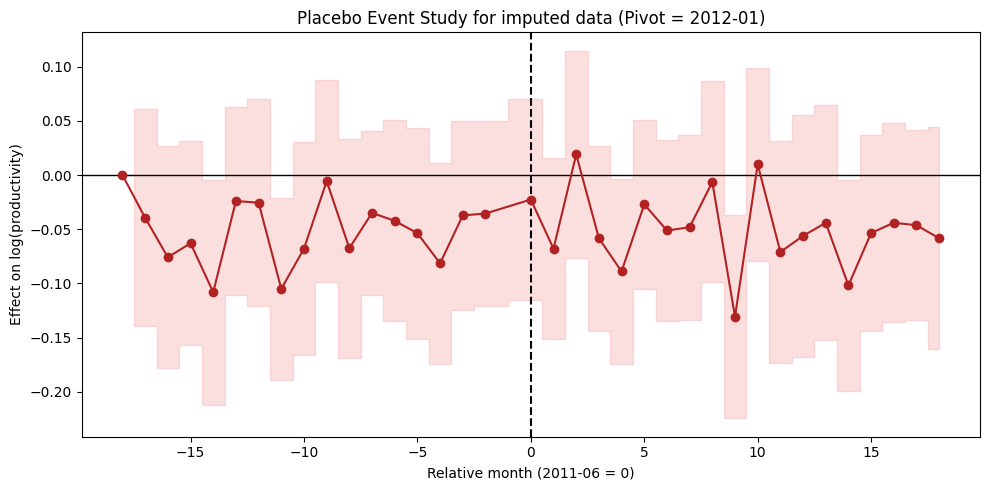

In [24]:
# Placebo test
t0_placebo = pd.Period('2011-06', freq='M').ordinal
df['rel_m_pl'] = df['date'].dt.to_period('M').astype(int) - t0_placebo
df_pl = df[(df['rel_m_pl']>=-18) & (df['rel_m_pl']<=18)].copy()
for k in range(-18, 19):
    if k == -1: continue
    df_pl[f'pl_{k}'] = ((df_pl['rel_m_pl']==k) & (df_pl['treat']==1)).astype(int)
terms_pl = ' + '.join([f"Q('pl_{k}')" for k in range(-18, 19) if k != -1])
res_pl = smf.wls(f'log_prod ~ {terms_pl} + C(firm_id) + C(date)',
                 data=df_pl, weights=df_pl['sw']).fit(cov_type='cluster', cov_kwds={'groups': df_pl['firm_id']})

betas_pl, lower_pl, upper_pl, rel_pl = [], [], [], []
for k in range(-18, 19):
    if k == -1: 
        continue
    name = f"Q('pl_{k}')"
    b = res_pl.params.get(name, np.nan)
    se = res_pl.bse.get(name, np.nan)
    if pd.notna(b) and pd.notna(se):
        betas_pl.append(b); lower_pl.append(b - 1.96*se); upper_pl.append(b + 1.96*se); rel_pl.append(k)

es_pl_df = pd.DataFrame({'rel_m': rel_pl, 'beta': betas_pl, 'lo': lower_pl, 'hi': upper_pl}).sort_values('rel_m')

plt.figure(figsize=(10,5))
plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linestyle='--')
plt.fill_between(es_pl_df['rel_m'], es_pl_df['lo'], es_pl_df['hi'], color='lightcoral', alpha=0.25, step='mid')
plt.plot(es_pl_df['rel_m'], es_pl_df['beta'], color='firebrick', marker='o')
plt.title('Placebo Event Study for imputed data (Pivot = 2012-01)')
plt.xlabel('Relative month (2011-06 = 0)')
plt.ylabel('Effect on log(productivity)')
plt.tight_layout()
plt.show()


### Matching score DID

logit(ps) SD=1.6019, caliper=0.2*SD=0.3204
Matching successful: 168/168 treated (caliper= 0.3204)
                            WLS Regression Results                            
Dep. Variable:               log_prod   R-squared:                       0.834
Model:                            WLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     33.76
Date:                Tue, 30 Sep 2025   Prob (F-statistic):          1.30e-100
Time:                        00:56:12   Log-Likelihood:                -6785.5
No. Observations:               26897   AIC:                         1.427e+04
Df Residuals:                   26547   BIC:                         1.714e+04
Df Model:                         349                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]


/Users/wangchengrui11/Desktop/PhD_application/Stanford_Data_Task_2025/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 349, but rank is 120
  warnings.warn('covariance of constraints does not have full '


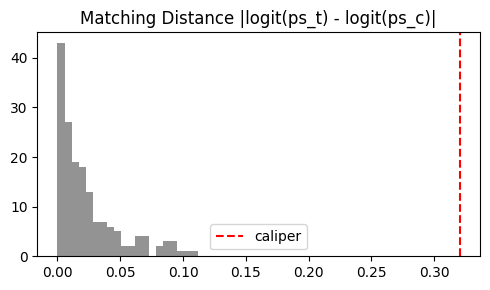

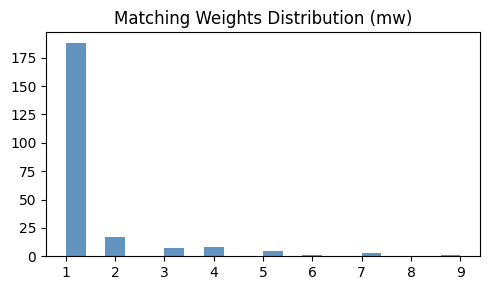

In [27]:
# Nearest Neighbor Matching with Caliper on logit(PS)

# Calculate logit(ps) and caliper
eps = 1e-6
X_firm['ps_clip'] = X_firm['ps'].clip(eps, 1-eps)
X_firm['logit_ps'] = np.log(X_firm['ps_clip']/(1 - X_firm['ps_clip']))
sd_logit = X_firm['logit_ps'].std(ddof=1)
caliper = 0.2 * sd_logit
print(f'logit(ps) SD={sd_logit:.4f}, caliper=0.2*SD={caliper:.4f}')

# Nearest Neighbor Matching within Caliper
treated = X_firm.loc[X_firm['treat']==1, ['firm_id','logit_ps']].reset_index(drop=True)
control = X_firm.loc[X_firm['treat']==0, ['firm_id','logit_ps']].reset_index(drop=True)

if len(treated)==0 or len(control)==0:
    raise RuntimeError('Matching not possible: no treated or control units after trimming')

nn = NearestNeighbors(n_neighbors=1).fit(control[['logit_ps']].to_numpy())
dist, idx = nn.kneighbors(treated[['logit_ps']].to_numpy(), n_neighbors=1, return_distance=True)
dist = dist.ravel(); idx = idx.ravel()

# Match pairs within caliper
pairs = []
for i, (d, j) in enumerate(zip(dist, idx)):
    if d <= caliper:
        t_id = treated.loc[i, 'firm_id']
        c_id = control.loc[j, 'firm_id']
        pairs.append({'treated_id': t_id, 'control_id': c_id, 'abs_logit_diff': float(d)})

pairs = pd.DataFrame(pairs)
matched_t = pairs['treated_id'].nunique() if not pairs.empty else 0
print(f'Matching successful: {matched_t}/{len(treated)} treated (caliper= {caliper:.4f})')

if pairs.empty:
    raise RuntimeError('Matching not possible: no pairs found within caliper')

# 4) Generate matching weights and map back to panel
ctrl_weight = pairs.groupby('control_id').size().rename('mw').reset_index()
treat_weight = pairs[['treated_id']].drop_duplicates().assign(mw=1).rename(columns={'treated_id':'firm_id'})
ctrl_weight = ctrl_weight.rename(columns={'control_id':'firm_id'})
mw = pd.concat([treat_weight, ctrl_weight], ignore_index=True)

matched_ids = set(mw['firm_id'])
df_m = df[df['firm_id'].isin(matched_ids)].copy()
df_m = df_m.merge(mw, on='firm_id', how='left')
df_m['mw'] = df_m['mw'].fillna(0)

# 5) Run DID (firm FE + time FE) on matched sample
mod_m = smf.wls('log_prod ~ did + C(firm_id) + C(date)', data=df_m, weights=df_m['mw'])
res_m = mod_m.fit(cov_type='cluster', cov_kwds={'groups': df_m['firm_id']})
print(res_m.summary().as_text())

tau_m = res_m.params.get('did', np.nan)
se_m  = res_m.bse.get('did', np.nan)
print(f'[Matching DID-logit Caliper] did={tau_m:.4f}, 95%CI [{tau_m-1.96*se_m:.4f}, {tau_m+1.96*se_m:.4f}]; matched firms={len(matched_ids)}')

# 6) Visualizations for matching quality
plt.figure(figsize=(5,3))
plt.hist(pairs['abs_logit_diff'], bins=20, color='gray', alpha=0.85)
plt.axvline(caliper, color='red', linestyle='--', label='caliper')
plt.title('Matching Distance |logit(ps_t) - logit(ps_c)|')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
plt.hist(mw['mw'], bins=20, color='steelblue', alpha=0.85)
plt.title('Matching Weights Distribution (mw)'); plt.tight_layout(); plt.show()

In [40]:
# Further result
specs = [
    {'name': '(1)', 'formula': 'did',                                              'firm_fe': False, 'time_fe': False, 'sect_trend': False},
    {'name': '(2)', 'formula': 'did + C(firm_id)',                                 'firm_fe': True,  'time_fe': False, 'sect_trend': False},
    {'name': '(3)', 'formula': 'did + C(firm_id) + C(date)',                       'firm_fe': True,  'time_fe': True,  'sect_trend': False},
    {'name': '(4)', 'formula': 'did + C(firm_id) + C(date) + C(firm_sector):t',    'firm_fe': True,  'time_fe': True,  'sect_trend': True},
]

match_results = []
for s in specs:
    try:
        mod_s = smf.wls(f"log_prod ~ {s['formula']}", data=df_m, weights=df_m['mw'])
        res_s = mod_s.fit(cov_type='cluster', cov_kwds={'groups': df_m['firm_id']})
        b  = float(res_s.params.get('did', np.nan))
        se = float(res_s.bse.get('did', np.nan))
        p  = float(res_s.pvalues.get('did', np.nan))
        n  = int(res_s.nobs)
        r2 = float(getattr(res_s, 'rsquared', np.nan))
    except Exception as e:
        b=se=p=r2=np.nan; n = int(len(df_m))
    match_results.append({'name': s['name'], 'b': b, 'se': se, 'p': p,
                          'firm_fe': s['firm_fe'], 'time_fe': s['time_fe'], 'sect_trend': s['sect_trend'],
                          'n': n, 'r2': r2})

In [41]:
# LaTeX table for matching results
colN = len(match_results)
header_specs = ' & ' + ' & '.join(r['name'] for r in match_results) + r' \\'
coef_vals = ' & '.join([f"{r['b']:.3f}{stars(r['p'])}" if np.isfinite(r['b']) else '' for r in match_results])
se_vals   = ' & '.join([f"({r['se']:.3f})" if np.isfinite(r['se']) else '' for r in match_results])
firm_fe_vals = ' & '.join([mark(r['firm_fe']) for r in match_results])
time_fe_vals = ' & '.join([mark(r['time_fe']) for r in match_results])
sect_trend_vals = ' & '.join([mark(r['sect_trend']) for r in match_results])
n_vals = ' & '.join([f"{r['n']:,}" for r in match_results])
r2_vals = ' & '.join([f"{r['r2']:.3f}" if np.isfinite(r['r2']) else '' for r in match_results])

latex_match_specs = rf"""
\begin{{table}}[!htbp]\centering
\caption{{Matching score DID Estimation Results}}
\label{{tab:match_did_specs}}
\begin{{threeparttable}}
\begin{{tabular}}{{l*{{{colN}}}{{c}}}}
\toprule
 & {header_specs}
\midrule
Post*Treat & {coef_vals} \\
           & {se_vals} \\
\midrule
Firm fixed effects & {firm_fe_vals} \\
Time fixed effects & {time_fe_vals} \\
Sector * Time trend & {sect_trend_vals} \\
\midrule
N & {n_vals} \\
$R^2$ & {r2_vals} \\
\bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\footnotesize
\item Note: Matching sample is estimated with WLS using matching weights, firm-clustered robust standard errors. $^{{***}}p<0.01$, $^{{**}}p<0.05$, $^{{*}}p<0.10$.
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
""".strip()

with open('table/match_did_specs_impute.tex', 'w') as f:
    f.write(latex_match_specs)

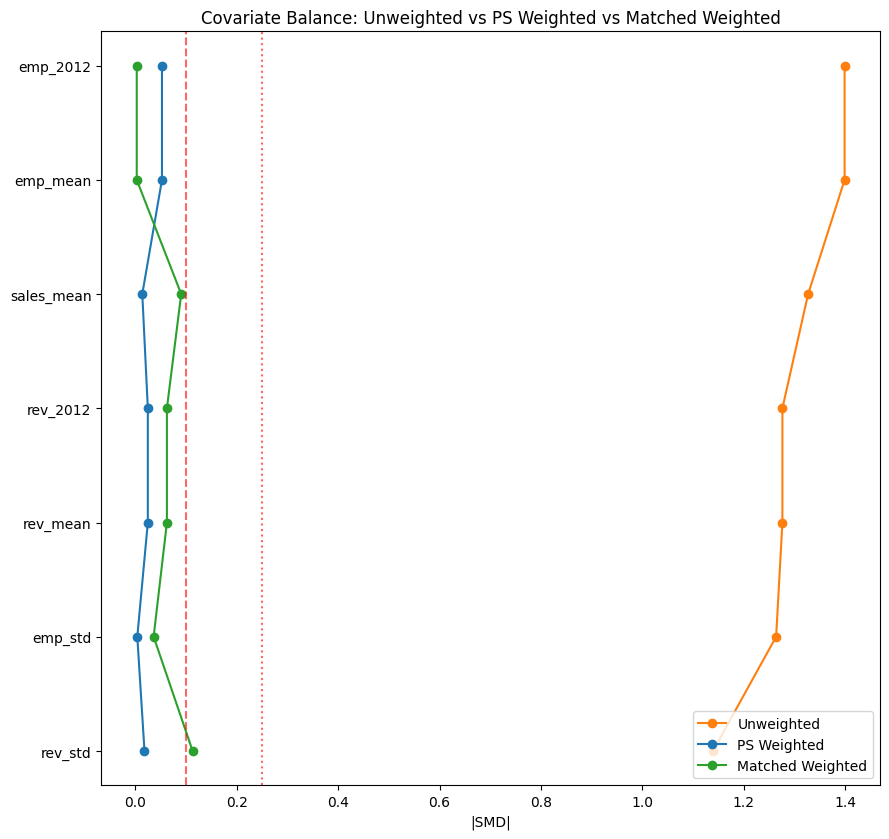

In [29]:
covs = ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']
W_match = mw.rename(columns={'mw':'w_m'})[['firm_id','w_m']].copy()
Xb = X_firm.merge(W_match, on='firm_id', how='left').fillna({'w_m':0})
Xb['w_sw'] = Xb['sw']

rows = []
for c in covs:
    a = pd.to_numeric(Xb.loc[Xb['treat']==1, c], errors='coerce').dropna()
    b = pd.to_numeric(Xb.loc[Xb['treat']==0, c], errors='coerce').dropna()
    wa0 = np.ones_like(a, dtype=float)
    wb0 = np.ones_like(b, dtype=float)
    wa_sw = Xb.loc[a.index, 'w_sw'].to_numpy()
    wb_sw = Xb.loc[b.index, 'w_sw'].to_numpy()
    wa_m = Xb.loc[a.index, 'w_m'].to_numpy()
    wb_m = Xb.loc[b.index, 'w_m'].to_numpy()

    smd_unw = smd(a.to_numpy(), b.to_numpy(), wa0, wb0)
    smd_sw  = smd(a.to_numpy(), b.to_numpy(), wa_sw, wb_sw)
    smd_m   = smd(a.to_numpy(), b.to_numpy(), wa_m,  wb_m)
    rows.append({'cov': c, 'unw': abs(smd_unw), 'psw': abs(smd_sw), 'match': abs(smd_m)})

love = pd.DataFrame(rows).sort_values('unw', ascending=True)
plt.figure(figsize=(9, 1.0*len(love)+1.5))
ypos = np.arange(len(love))
plt.plot(love['unw'],   ypos, 'o-', label='Unweighted', color='tab:orange')
plt.plot(love['psw'],   ypos, 'o-', label='PS Weighted', color='tab:blue')
plt.plot(love['match'], ypos, 'o-', label='Matched Weighted', color='tab:green')
for thr, ls in [(0.1, '--'), (0.25, ':')]:
    plt.axvline(thr, color='red', linestyle=ls, alpha=0.6)
plt.yticks(ypos, love['cov'])
plt.xlabel('|SMD|')
plt.title('Covariate Balance: Unweighted vs PS Weighted vs Matched Weighted')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('graph/love_plot_comparison.png', dpi=200)
plt.show()


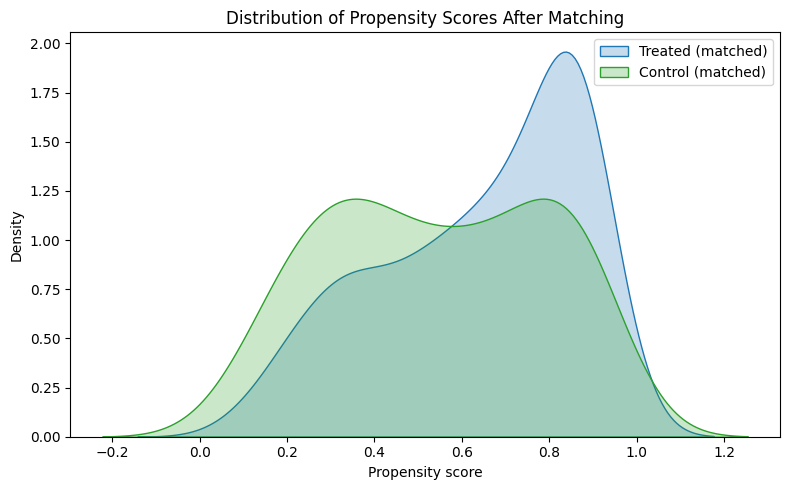

In [36]:
# Distribution of PS after matching
matched_ctrl_ids = set(pairs['control_id'])
matched_treat_ids = set(pairs['treated_id'])
ps_t = X_firm.loc[X_firm['firm_id'].isin(matched_treat_ids) & (X_firm['treat']==1), 'ps']
ps_c = X_firm.loc[X_firm['firm_id'].isin(matched_ctrl_ids)  & (X_firm['treat']==0), 'ps']

plt.figure(figsize=(8,5))
sns.kdeplot(ps_t, label='Treated (matched)', fill=True, color='tab:blue')
sns.kdeplot(ps_c, label='Control (matched)', fill=True, color='tab:green')
plt.title('Distribution of Propensity Scores After Matching')
plt.xlabel('Propensity score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('graph/match_ps_density.png', dpi=200)
plt.show()

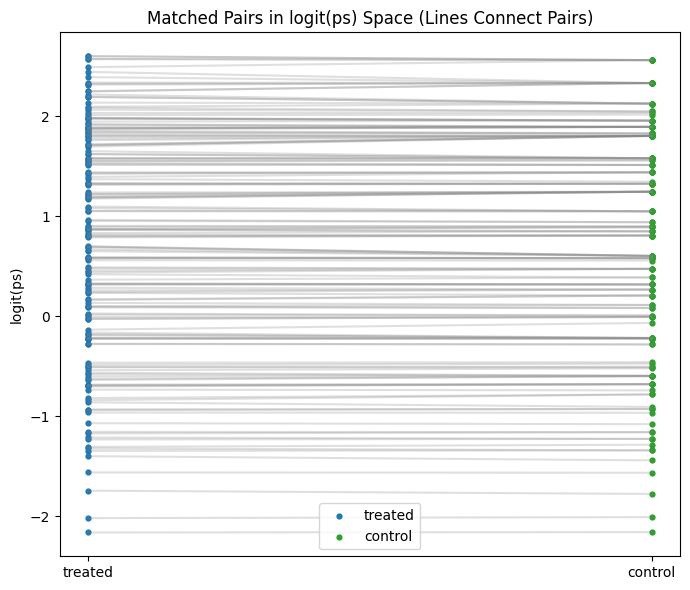

In [31]:
# Visualize matched pairs in logit(ps) space
treated_l = X_firm[['firm_id','logit_ps']].rename(columns={'logit_ps':'logit_t'}).set_index('firm_id')
control_l = X_firm[['firm_id','logit_ps']].rename(columns={'logit_ps':'logit_c'}).set_index('firm_id')
pp = pairs.copy()
pp['logit_t'] = treated_l.loc[pp['treated_id'], 'logit_t'].values
pp['logit_c'] = control_l.loc[pp['control_id'], 'logit_c'].values

plt.figure(figsize=(7,6))
for _, r in pp.iterrows():
    plt.plot([0,1], [r['logit_t'], r['logit_c']], color='gray', alpha=0.25)
plt.scatter(np.zeros(len(pp)), pp['logit_t'], color='tab:blue', s=12, label='treated')
plt.scatter(np.ones(len(pp)),  pp['logit_c'], color='tab:green', s=12, label='control')
plt.xticks([0,1], ['treated','control'])
plt.ylabel('logit(ps)')
plt.title('Matched Pairs in logit(ps) Space (Lines Connect Pairs)')
plt.legend()
plt.tight_layout()
plt.savefig('graph/match_pair_logit_lines.png', dpi=200)
plt.show()

### DR-DID

In [28]:
# Augmented Inverse Probability Weighting (AIPW) / Doubly Robust DID (DR-DID) estimation

pre_df  = df.loc[df['post']==0, ['firm_id','log_prod']].groupby('firm_id', as_index=False)['log_prod'].mean().rename(columns={'log_prod':'y_pre'})
post_df = df.loc[df['post']==1, ['firm_id','log_prod']].groupby('firm_id', as_index=False)['log_prod'].mean().rename(columns={'log_prod':'y_post'})
dd = pre_df.merge(post_df, on='firm_id', how='inner')
dd['dY'] = dd['y_post'] - dd['y_pre']

# Synthesize by covariating
base_cols = ['firm_id','treat','ps'] + ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012','firm_sector']
z = dd.merge(X_firm[base_cols], on='firm_id', how='inner').dropna(subset=['ps','treat'])

# Characteristics for outcome regression
Z = z[['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']].copy()
if 'firm_sector' in z.columns:
    Z = pd.concat([Z, pd.get_dummies(z['firm_sector'], prefix='sec', drop_first=True)], axis=1).astype(float)

# Outcome model: Fit E[dY|X] using control group only
ctrl = z['treat']==0
reg = LinearRegression().fit(Z[ctrl], z.loc[ctrl, 'dY'])
mhat = reg.predict(Z)

# AIPW/DR-DID ATT
T = z['treat'].values.astype(int)
ps = z['ps'].clip(1e-6, 1-1e-6).values
dY = z['dY'].values
resid = dY - mhat

# Normalize weights (control group)
w_ctrl = ps/(1-ps)
w_ctrl_norm = w_ctrl[~T.astype(bool)]
w_ctrl_norm = w_ctrl_norm / w_ctrl_norm.sum()

att_treated = resid[T==1].mean()
att_control = np.sum(w_ctrl_norm * resid[T==0])
att_dr = att_treated - att_control
print(f'[AIPW-DRDID] ATT_DR={att_dr:.4f} (point estimate)')

# Simple firm-level bootstrap CI
B = 200
rng = np.random.default_rng(42)
boot = []
firm_ids = z['firm_id'].unique()
for _ in range(B):
    samp = rng.choice(firm_ids, size=len(firm_ids), replace=True)
    zz = z.set_index('firm_id').loc[samp].reset_index()

    ZZ = zz[['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']].copy()
    if 'firm_sector' in zz.columns:
        ZZ = pd.concat([ZZ, pd.get_dummies(zz['firm_sector'], prefix='sec', drop_first=True)], axis=1).astype(float)

    T_b  = zz['treat'].values.astype(int)
    ps_b = zz['ps'].clip(1e-6, 1-1e-6).values
    dY_b = zz['dY'].values

    reg_b = LinearRegression().fit(ZZ[T_b==0], dY_b[T_b==0])
    mhat_b = reg_b.predict(ZZ)
    resid_b = dY_b - mhat_b

    w_b = ps_b/(1-ps_b)
    w_b_norm = w_b[T_b==0]; w_b_norm = w_b_norm / w_b_norm.sum()

    att_b = resid_b[T_b==1].mean() - np.sum(w_b_norm * resid_b[T_b==0])
    boot.append(att_b)

boot = np.array(boot)
se_dr = boot.std(ddof=1)
ci_lo, ci_hi = att_dr - 1.96*se_dr, att_dr + 1.96*se_dr
print(f'[AIPW-DRDID] 95% CI [{ci_lo:.4f}, {ci_hi:.4f}] (B={B} bootstrap)')

[AIPW-DRDID] ATT_DR=0.4192 (point estimate)
[AIPW-DRDID] 95% CI [0.3431, 0.4953] (B=200 bootstrap)


In [43]:
specs = [
    {'name': '(1)', 'firm_fe': False, 'time_fe': False, 'sect_trend': False},
    {'name': '(2)', 'firm_fe': True,  'time_fe': False, 'sect_trend': False},  # FE 不适用，仅标注
    {'name': '(3)', 'firm_fe': True,  'time_fe': True,  'sect_trend': False},  # FE 不适用，仅标注
    {'name': '(4)', 'firm_fe': True,  'time_fe': True,  'sect_trend': True},
]

dr_cols = []
for s in specs:
    # Fit outcome model E[dY|X] using control group only
    Zs = build_features(z, s['sect_trend'])
    ctrl = z['treat']==0
    reg_s = LinearRegression().fit(Zs[ctrl], z.loc[ctrl, 'dY'])
    mhat_s = reg_s.predict(Zs)

    T = z['treat'].values.astype(int)
    psv = z['ps'].clip(1e-6, 1-1e-6).values
    dYv = z['dY'].values
    resid_s = dYv - mhat_s

    w_ctrl = psv/(1-psv)
    w_ctrl_norm = w_ctrl[T==0]
    w_ctrl_norm = w_ctrl_norm / w_ctrl_norm.sum()

    att_s = resid_s[T==1].mean() - np.sum(w_ctrl_norm * resid_s[T==0])

    # bootstrap to get SE
    B = 200
    rng = np.random.default_rng(42)
    boot_s = []
    firm_ids = z['firm_id'].unique()
    for _ in range(B):
        samp = rng.choice(firm_ids, size=len(firm_ids), replace=True)
        zz = z.set_index('firm_id').loc[samp].reset_index()
        ZZ = build_features(zz, s['sect_trend'])
        Tb  = zz['treat'].values.astype(int)
        psb = zz['ps'].clip(1e-6, 1-1e-6).values
        dYb = zz['dY'].values

        reg_b = LinearRegression().fit(ZZ[Tb==0], dYb[Tb==0])
        mhat_b = reg_b.predict(ZZ)
        resid_b = dYb - mhat_b

        wb = psb/(1-psb)
        wb_norm = wb[Tb==0]; wb_norm = wb_norm / wb_norm.sum()

        att_b = resid_b[Tb==1].mean() - np.sum(wb_norm * resid_b[Tb==0])
        boot_s.append(att_b)

    boot_s = np.array(boot_s)
    se_s = float(boot_s.std(ddof=1))
    p_s = float(2*(1 - stats.norm.cdf(abs(att_s)/se_s))) if se_s>0 and np.isfinite(att_s) else np.nan

    dr_cols.append({
        'name': s['name'], 'att': att_s, 'se': se_s, 'p': p_s,
        'firm_fe': s['firm_fe'], 'time_fe': s['time_fe'], 'sect_trend': s['sect_trend'],
        'n': int(len(z))
    })

In [44]:
# Generate LaTeX table for DR-DID results
colN = len(dr_cols)
header_specs = ' & ' + ' & '.join(c['name'] for c in dr_cols) + r' \\'
coef_vals = ' & '.join([f"{c['att']:.3f}{stars(c['p'])}" if np.isfinite(c['att']) else '' for c in dr_cols])
se_vals   = ' & '.join([f"({c['se']:.3f})" if np.isfinite(c['se']) else '' for c in dr_cols])
firm_fe_vals = ' & '.join([mark(c['firm_fe']) for c in dr_cols])
time_fe_vals = ' & '.join([mark(c['time_fe']) for c in dr_cols])
sect_trend_vals = ' & '.join([mark(c['sect_trend']) for c in dr_cols])
n_vals    = ' & '.join([f"{c['n']:,}" for c in dr_cols])

latex_drdid_specs = rf"""
\begin{{table}}[!htbp]\centering
\caption{{Estimation Results from Doubly Robust DID (DR-DID)}}
\label{{tab:drdid_specs}}
\begin{{threeparttable}}
\begin{{tabular}}{{l*{{{colN}}}{{c}}}}
\toprule
 & {header_specs}
\midrule
ATT\_DR & {coef_vals} \\
        & {se_vals} \\
\midrule
Firm fixed effects & {firm_fe_vals} \\
Time fixed effects & {time_fe_vals} \\
Sector * Time trend & {sect_trend_vals} \\
\midrule
N (firms) & {n_vals} \\
\bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\footnotesize
\item Note: DR-DID is calculated on the firm-level dY=Y\_post-Y\_pre cross-section; "Firm FE/Time FE" is not directly applicable and is only used as a specification label here. Specification (4) includes industry dummies in mhat to capture industry time trends. SE is based on firm-level bootstrap (B=200).
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
""".strip()

with open('table/drdid_specs_impute.tex', 'w') as f:
    f.write(latex_drdid_specs)

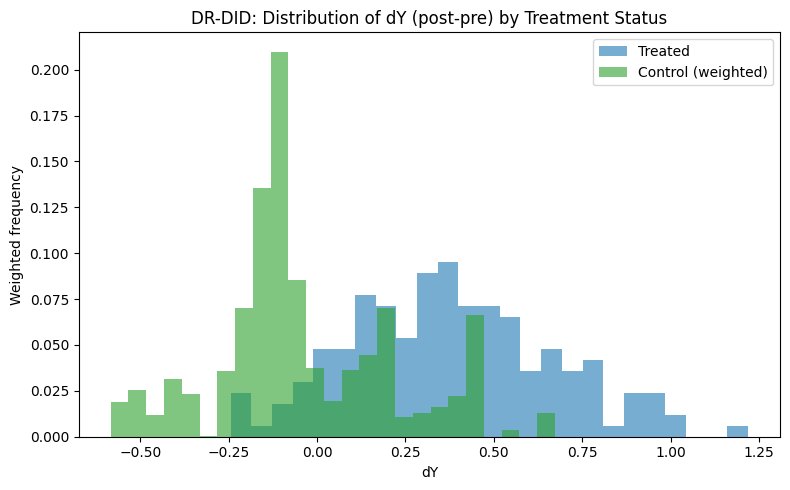

In [32]:
# Visualize dY distribution in treated vs control (weighted)
T = z['treat'].values.astype(int)
dY = z['dY'].values
tw = np.ones((T==1).sum(), dtype=float); tw /= tw.sum()
cw = w_ctrl_norm

plt.figure(figsize=(8,5))
plt.hist(dY[T==1], bins=25, weights=tw, alpha=0.6, label='Treated', color='tab:blue')
plt.hist(dY[T==0], bins=25, weights=cw, alpha=0.6, label='Control (weighted)', color='tab:green')
plt.title('DR-DID: Distribution of dY (post-pre) by Treatment Status')
plt.xlabel('dY')
plt.ylabel('Weighted frequency')
plt.legend()
plt.tight_layout()
plt.savefig('graph/drdid_dY_hist.png', dpi=200)
plt.show()

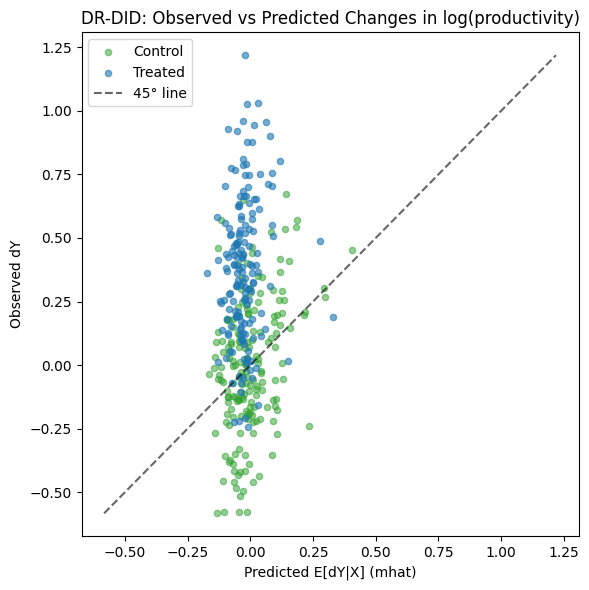

In [33]:
# Visualize predicted vs observed changes

plt.figure(figsize=(6,6))
plt.scatter(mhat[T==0], dY[T==0], s=20, alpha=0.5, label='Control', color='tab:green')
plt.scatter(mhat[T==1], dY[T==1], s=20, alpha=0.6, label='Treated', color='tab:blue')
lims = [min(dY.min(), mhat.min()), max(dY.max(), mhat.max())]
plt.plot(lims, lims, 'k--', alpha=0.6, label='45° line')
plt.xlabel('Predicted E[dY|X] (mhat)')
plt.ylabel('Observed dY')
plt.title('DR-DID: Observed vs Predicted Changes in log(productivity)')
plt.legend()
plt.tight_layout()
plt.savefig('graph/drdid_mhat_scatter.png', dpi=200)
plt.show()

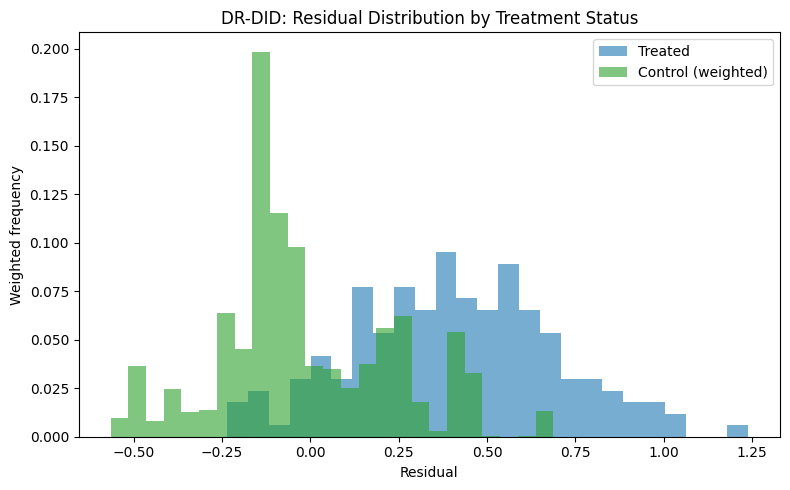

In [34]:
# Visualize residual distribution in treated vs control (weighted)
plt.figure(figsize=(8,5))
rt = resid[T==1]; rc = resid[T==0]
tw = np.ones_like(rt)/len(rt)
cw = w_ctrl_norm
plt.hist(rt, bins=25, weights=tw, alpha=0.6, label='Treated', color='tab:blue')
plt.hist(rc, bins=25, weights=cw, alpha=0.6, label='Control (weighted)', color='tab:green')
plt.title('DR-DID: Residual Distribution by Treatment Status')
plt.xlabel('Residual')
plt.ylabel('Weighted frequency')
plt.legend()
plt.tight_layout()
plt.savefig('graph/drdid_resid_hist.png', dpi=200)
plt.show()

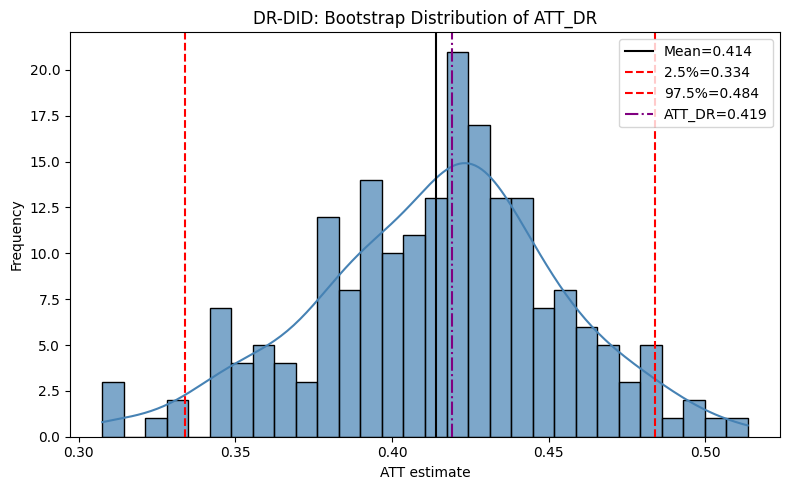

In [35]:
# Visualize bootstrap distribution of ATT_DR
plt.figure(figsize=(8,5))
sns.histplot(boot, bins=30, kde=True, color='steelblue', alpha=0.7)
ci_lo, ci_hi = np.percentile(boot, [2.5, 97.5])
plt.axvline(np.mean(boot), color='k', linestyle='-', label=f'Mean={np.mean(boot):.3f}')
plt.axvline(ci_lo, color='red', linestyle='--', label=f'2.5%={ci_lo:.3f}')
plt.axvline(ci_hi, color='red', linestyle='--', label=f'97.5%={ci_hi:.3f}')
plt.axvline(att_dr, color='purple', linestyle='-.', label=f'ATT_DR={att_dr:.3f}')
plt.title('DR-DID: Bootstrap Distribution of ATT_DR')
plt.xlabel('ATT estimate')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('graph/drdid_bootstrap_att.png', dpi=200)
plt.show()

### Heterogeneity

In [38]:
sectors = sorted([s for s in df['firm_sector'].dropna().unique().tolist()])
bysec = []

for sec in sectors:
    dsec = df.loc[df['firm_sector']==sec].copy()
    ok = True
    try:
        mod_s = smf.wls('log_prod ~ did + C(firm_id) + C(date)', data=dsec, weights=dsec['sw'])
        res_s = mod_s.fit(cov_type='cluster', cov_kwds={'groups': dsec['firm_id']})
        b  = float(res_s.params.get('did', np.nan))
        se = float(res_s.bse.get('did', np.nan))
        p  = float(res_s.pvalues.get('did', np.nan))
        n  = int(res_s.nobs)
        r2 = float(getattr(res_s, 'rsquared', np.nan))
    except Exception as e:
        ok = False
        b=se=p=r2=np.nan; n = int(len(dsec))
    bysec.append({'sector': sec, 'b': b, 'se': se, 'p': p, 'n': n, 'r2': r2, 'ok': ok})

In [39]:
# Generate LaTeX table for sectoral results
hdr = ' & ' + ' & '.join(latex_escape(x['sector']) for x in bysec) + r' \\'
coef_vals = ' & '.join([f"{x['b']:.3f}{stars(x['p'])}" if np.isfinite(x['b']) else '' for x in bysec])
se_vals = ' & '.join([f"({x['se']:.3f})"           if np.isfinite(x['se']) else '' for x in bysec])
n_vals = ' & '.join([f"{x['n']:,}" for x in bysec])
r2_vals = ' & '.join([f"{x['r2']:.3f}" if np.isfinite(x['r2']) else '' for x in bysec])

latex_bysec = rf"""
\begin{{table}}[!htbp]\centering
\caption{{Outcome by Sector (PSM-DID)}}
\label{{tab:psm_did_by_sector}}
\begin{{threeparttable}}
\begin{{tabular}}{{l*{{{len(bysec)}}}{{c}}}}
\toprule
 & {hdr}
\midrule
Post*Treat & {coef_vals} \\
           & {se_vals} \\
\midrule
N          & {n_vals} \\
$R^2$      & {r2_vals} \\
\bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\footnotesize
Note: dependent variable is specified as log(productivity). Each column corresponds to a regression in the respective sector sample weighted by PS stabilized weights, with standard errors clustered at the firm level. $^{{***}}p<0.01$, $^{{**}}p<0.05$, $^{{*}}p<0.10$.
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
""".strip()

with open('table/psm_did_by_sector_impute.tex', 'w') as f:
    f.write(latex_bysec)

### 